In [21]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

# Import modules from your project.
from data.synthetic_data import generate_synthetic_data
from methods.lasso_cd import lasso_coordinate_descent
from methods.lasso_fista import lasso_fista
from methods.lasso_ista import lasso_ista
from methods.square_root_lasso import square_root_lasso
from utils.plotting import plot_coefficient_evolution  # Your custom plotting function.

# Define your configuration directly in the notebook.
config = {
    "dataset": {
        "type": "synthetic",
        "n_samples": 100,
        "n_features": 1000,
        "n_informative": 20,
        "noise": 1,  # This value will be overwritten by the loop.
        "random_state": 42
    },
    "algorithms": {
        "lasso_cd": {
            "lam": 0.1,
            "max_iter": 5000,
            "tol": 1e-4,
            "threshold": 1e-2
        },
        "lasso_fista": {
            "lam": 0.1,
            "max_iter": 5000,
            "tol": 1e-4,
            "threshold": 0.1
        },
        "lasso_ista": {
            "lam": 0.1,
            "max_iter": 100000,
            "tol": 1e-4,
            "threshold": 0.1
        },
        "square_root_lasso": {
            "tau": 0.2,
            "max_outer_iter": 250,
            "tol": 1e-4,
            "threshold": 0.0
        }
    }
}

def run_experiment(algo_name, X_scaled, y_centered, config_algo):
    print(f"Running experiment for {algo_name}...")
    if algo_name == "lasso_cd":
        beta_est, beta_history = lasso_coordinate_descent(
            X_scaled, y_centered,
            lam=config_algo["lam"],
            max_iter=config_algo["max_iter"],
            tol=config_algo["tol"]
        )
    elif algo_name == "lasso_fista":
        beta_est, beta_history = lasso_fista(
            X_scaled, y_centered,
            lam=config_algo["lam"],
            max_iter=config_algo["max_iter"],
            tol=config_algo["tol"]
        )
    elif algo_name == "lasso_ista":
        beta_est, beta_history = lasso_ista(
            X_scaled, y_centered,
            lam=config_algo["lam"],
            max_iter=config_algo["max_iter"],
            tol=config_algo["tol"]
        )
    elif algo_name == "square_root_lasso":
        beta_est, sigma_est, beta_history = square_root_lasso(
            X_scaled, y_centered,
            tau=config_algo["tau"],
            max_outer_iter=config_algo["max_outer_iter"],
            tol=config_algo["tol"]
        )
        # For square-root LASSO, extract only the beta vectors from the history.
        beta_history_arr = np.array([b for sigma, b in beta_history])
        return beta_est, beta_history_arr
    else:
        raise ValueError("Unknown algorithm")
    
    beta_history_arr = np.array(beta_history)
    return beta_est, beta_history_arr

def evaluate_and_plot(beta_est, beta_history_arr, true_informative_indices, X_scaled, config_algo, algo_name):
    threshold = config_algo.get("threshold", 1e-2)
    selected_indices = np.where(beta_est > threshold)[0]
    n_features = X_scaled.shape[1]
    n_selected = len(selected_indices)
    n_not_selected = n_features - n_selected

    print(f"\n{algo_name} results:")
    print("Number of features selected (nonzero coefficients):", n_selected)
    print("Indices of selected features:", selected_indices)
    
    common_features = set(selected_indices).intersection(set(true_informative_indices))
    correct_count = len(common_features)
    wrong_count = n_selected - correct_count
    fraction = correct_count / len(true_informative_indices) if len(true_informative_indices) > 0 else 0

    print("Recovered informative features (intersection):", sorted(common_features))
    print("Fraction of ground truth features recovered: {}/{} = {:.2f}".format(
        correct_count, len(true_informative_indices), fraction))
    
    # Optionally, plot the coefficient evolution.
    # plot_coefficient_evolution(beta_history_arr, selected_indices, n_features)
    
    return {
        "n_selected": n_selected,
        "selected_indices": selected_indices.tolist(),
        "correct_count": correct_count,
        "wrong_count": wrong_count,
        "fraction_recovered": fraction,
        "beta_history_shape": beta_history_arr.shape,
        "beta_history": beta_history_arr
    }

# Define a list of noise levels to test.
noise_levels = [0, 1, 3, 5, 10, 30]
# Create a list to store experiment results.
results = []

# Outer loop: vary the noise level.
for noise in noise_levels:
    # Update noise in the dataset configuration.
    data_config = config["dataset"].copy()
    data_config["noise"] = noise

    # Generate the synthetic dataset.
    X_data, y_data, true_coef = generate_synthetic_data(
        n_samples=data_config["n_samples"],
        n_features=data_config["n_features"],
        n_informative=data_config["n_informative"],
        noise=data_config["noise"],
        random_state=data_config["random_state"]
    )
    true_informative_indices = np.where(true_coef != 0)[0]

    # Standardize the data.
    X_mean = np.mean(X_data, axis=0)
    X_std = np.std(X_data, axis=0)
    X_scaled = (X_data - X_mean) / X_std
    y_centered = y_data - np.mean(y_data)
    
    # Inner loop: run each algorithm.
    for algo_name, algo_config in config["algorithms"].items():
        start_time = time.time()
        beta_est, beta_history_arr = run_experiment(algo_name, X_scaled, y_centered, algo_config)
        elapsed_time = time.time() - start_time
        
        metrics = evaluate_and_plot(beta_est, beta_history_arr, true_informative_indices, X_scaled, algo_config, algo_name)
        
        results.append({
            "Algorithm": algo_name,
            "Noise": noise,
            "Time (s)": elapsed_time,
            "n_selected": metrics["n_selected"],
            "Selected Indices": metrics["selected_indices"],
            "Correct Count": metrics["correct_count"],
            "Wrong Count": metrics["wrong_count"],
            "Fraction Recovered": metrics["fraction_recovered"],
            "Beta History Shape": metrics["beta_history_shape"],
            "Beta History": metrics["beta_history"],
            "Parameters": algo_config
        })

# Convert results to a DataFrame.
results_df = pd.DataFrame(results)
print("\nExperiment Results:")
display(results_df)


Running experiment for lasso_cd...
Converged at iteration 2090

lasso_cd results:
Number of features selected (nonzero coefficients): 33
Indices of selected features: [ 61 101 118 123 124 152 263 294 310 444 488 491 512 550 574 576 614 618
 630 660 674 694 705 728 743 793 803 831 858 876 878 915 921]
Recovered informative features (intersection): [np.int64(61), np.int64(101), np.int64(118), np.int64(123), np.int64(124), np.int64(263), np.int64(488), np.int64(550), np.int64(576), np.int64(614), np.int64(618), np.int64(630), np.int64(674), np.int64(694), np.int64(705), np.int64(793), np.int64(803), np.int64(831), np.int64(915), np.int64(921)]
Fraction of ground truth features recovered: 20/20 = 1.00
Running experiment for lasso_fista...
FISTA converged at iteration 2310

lasso_fista results:
Number of features selected (nonzero coefficients): 20
Indices of selected features: [ 61 101 118 123 124 263 488 550 576 614 618 630 674 694 705 793 803 831
 915 921]
Recovered informative features 

,Algorithm,Noise,Time (s),n_selected,Selected Indices,Correct Count,Wrong Count,Fraction Recovered,Beta History Shape,Beta History,Parameters
0,lasso_cd,0,20.735965,33,"[61, 101, 118, 123, 124, 152, 263, 294, 310, 4...",20,13,1.00,"(2091, 1000)","[[-17.49956315914905, 18.785991692245943, -64....","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
1,lasso_fista,0,0.086502,20,"[61, 101, 118, 123, 124, 263, 488, 550, 576, 6...",20,0,1.00,"(2311, 1000)","[[-1.033078319494488, 0.9515958705222818, -3.8...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
2,lasso_ista,0,2.087967,20,"[61, 101, 118, 123, 124, 263, 488, 550, 576, 6...",20,0,1.00,"(60047, 1000)","[[-1.033078319494488, 0.9515958705222818, -3.8...","{'lam': 0.1, 'max_iter': 100000, 'tol': 0.0001..."
3,square_root_lasso,0,40.161472,69,"[38, 39, 61, 101, 118, 123, 124, 142, 152, 154...",20,49,1.00,"(250, 1000)","[[-0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0,...","{'tau': 0.2, 'max_outer_iter': 250, 'tol': 0.0..."
4,lasso_cd,1,27.838567,57,"[39, 40, 80, 119, 150, 180, 185, 188, 205, 238...",20,37,1.00,"(2855, 1000)","[[-10.462899704492774, -3.738390871568768, -26...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
5,lasso_fista,1,0.140922,36,"[119, 150, 180, 205, 269, 287, 291, 299, 341, ...",20,16,1.00,"(3776, 1000)","[[-0.6176722667563075, -0.23777369700632098, -...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
6,lasso_ista,1,2.366557,41,"[80, 119, 150, 180, 205, 245, 269, 287, 291, 2...",20,21,1.00,"(68990, 1000)","[[-0.6176722667563075, -0.23777369700632098, -...","{'lam': 0.1, 'max_iter': 100000, 'tol': 0.0001..."
7,square_root_lasso,1,10.631013,44,"[45, 119, 150, 180, 188, 205, 245, 267, 269, 2...",20,24,1.00,"(101, 1000)","[[-0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0...","{'tau': 0.2, 'max_outer_iter': 250, 'tol': 0.0..."
8,lasso_cd,3,37.470902,62,"[37, 39, 40, 80, 150, 180, 205, 235, 245, 269,...",18,44,0.90,"(3850, 1000)","[[-10.786440071035138, -3.7470078542433436, -2...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
9,lasso_fista,3,0.182011,56,"[37, 39, 40, 150, 180, 205, 235, 245, 269, 277...",18,38,0.90,"(5000, 1000)","[[-0.6367723171470776, -0.23881054210507985, -...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."


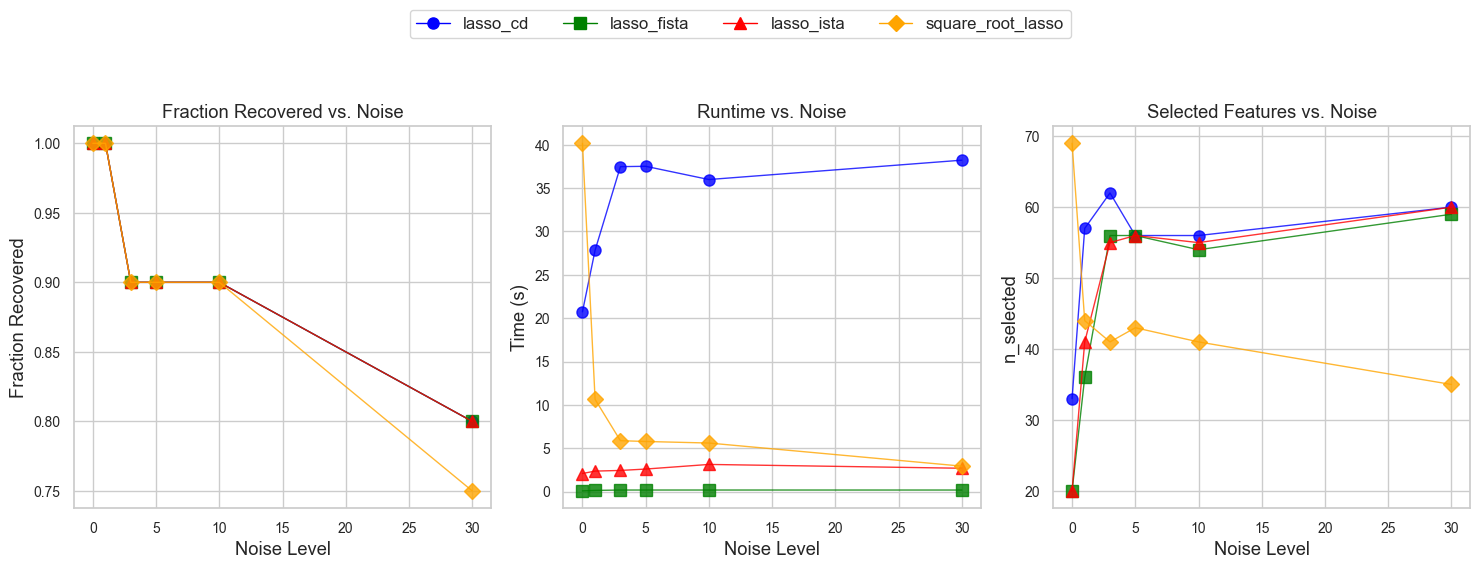

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Define a consistent color mapping for each algorithm.
color_map = {
    "lasso_cd": "blue",
    "lasso_fista": "green",
    "lasso_ista": "red",
    "square_root_lasso": "orange"
}

# Define a marker mapping for each algorithm.
marker_map = {
    "lasso_cd": "o",       # circle
    "lasso_fista": "s",     # square
    "lasso_ista": "^",      # triangle up
    "square_root_lasso": "D"  # diamond
}

# Set the style for a common grid.
sns.set(style="whitegrid", font_scale=1.1)

# Create a one-row, three-column grid of subplots sharing the same x-axis.
fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), sharex=True)

# Retrieve the unique algorithms from the results DataFrame.
algorithms = results_df["Algorithm"].unique()

# Loop through each algorithm and plot the corresponding metrics.
for algo in algorithms:
    # Filter the DataFrame for the current algorithm.
    df_algo = results_df[results_df["Algorithm"] == algo]
    clr = color_map.get(algo, "black")
    marker = marker_map.get(algo, "o")
    
    # Plot Fraction Recovered vs. Noise.
    axes[0].plot(df_algo["Noise"], df_algo["Fraction Recovered"], 
                 marker=marker, color=clr, markersize=8, linewidth=1, label=algo, alpha=0.8)
    axes[0].set_title("Fraction Recovered vs. Noise")
    axes[0].set_ylabel("Fraction Recovered")
    
    # Plot Runtime vs. Noise.
    axes[1].plot(df_algo["Noise"], df_algo["Time (s)"], 
                 marker=marker, color=clr, markersize=8, linewidth=1, label=algo, alpha=0.8)
    axes[1].set_title("Runtime vs. Noise")
    axes[1].set_ylabel("Time (s)")
    
    # Plot Number of Selected Features vs. Noise.
    axes[2].plot(df_algo["Noise"], df_algo["n_selected"], 
                 marker=marker, color=clr, markersize=8, linewidth=1, label=algo, alpha=0.8)
    axes[2].set_title("Selected Features vs. Noise")
    axes[2].set_ylabel("n_selected")

# Set a common x-label for all subplots.
for ax in axes:
    ax.set_xlabel("Noise Level")
    ax.tick_params(axis='both', labelsize=10)

# Create custom legend handles with different markers.
legend_handles = [Line2D([0], [0], color=color_map[algo], marker=marker_map[algo],
                           markersize=8, linewidth=1, label=algo)
                  for algo in algorithms]

# Add a common legend at the top of the figure.
fig.legend(handles=legend_handles, loc="upper center", ncol=len(algorithms), bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [29]:
def run_experiment_sweep(sweep_key, sweep_values, config, sweep_target="dataset"):
    """
    Runs experiments over a sweep of parameter values and returns a DataFrame of results.
    
    Parameters:
      sweep_key: The key (e.g., "noise" or "n_informative") to vary.
      sweep_values: A list of values to try for that key.
      config: The base configuration dictionary.
      sweep_target: The sub-dictionary to update, e.g., "dataset" (by default).
      
    Returns:
      A Pandas DataFrame containing the results for each parameter value.
    """
    results = []
    
    # Loop over each value in the sweep.
    for value in sweep_values:
        # Make a copy of the dataset configuration and update the sweep key.
        data_config = config["dataset"].copy()
        data_config[sweep_key] = value
        
        # Generate the synthetic dataset.
        X_data, y_data, true_coef = generate_synthetic_data(
            n_samples=data_config["n_samples"],
            n_features=data_config["n_features"],
            n_informative=data_config["n_informative"],
            noise=data_config["noise"],
            random_state=data_config["random_state"]
        )
        true_informative_indices = np.where(true_coef != 0)[0]
        
        # Standardize the data.
        X_mean = np.mean(X_data, axis=0)
        X_std = np.std(X_data, axis=0)
        X_scaled = (X_data - X_mean) / X_std
        y_centered = y_data - np.mean(y_data)
        
        # Loop over each algorithm in the configuration.
        for algo_name, algo_config in config["algorithms"].items():
            start_time = time.time()
            beta_est, beta_history_arr = run_experiment(algo_name, X_scaled, y_centered, algo_config)
            elapsed_time = time.time() - start_time
            
            metrics = evaluate_and_plot(beta_est, beta_history_arr, true_informative_indices, X_scaled, algo_config, algo_name)
            
            # Store results for this run.
            results.append({
                "Algorithm": algo_name,
                sweep_key: value,
                "Time (s)": elapsed_time,
                "n_selected": metrics["n_selected"],
                "Selected Indices": metrics["selected_indices"],
                "Correct Count": metrics["correct_count"],
                "Wrong Count": metrics["wrong_count"],
                "Fraction Recovered": metrics["fraction_recovered"],
                "Beta History Shape": metrics["beta_history_shape"],
                "Beta History": metrics["beta_history"],
                "Parameters": algo_config
            })
    return pd.DataFrame(results)


In [30]:
# Define the noise levels you want to test.
noise_levels = [0, 1, 3, 5, 10, 30]
results_noise = run_experiment_sweep("noise", noise_levels, config)
display(results_noise)

Running experiment for lasso_cd...
Converged at iteration 2090

lasso_cd results:
Number of features selected (nonzero coefficients): 33
Indices of selected features: [ 61 101 118 123 124 152 263 294 310 444 488 491 512 550 574 576 614 618
 630 660 674 694 705 728 743 793 803 831 858 876 878 915 921]
Recovered informative features (intersection): [np.int64(61), np.int64(101), np.int64(118), np.int64(123), np.int64(124), np.int64(263), np.int64(488), np.int64(550), np.int64(576), np.int64(614), np.int64(618), np.int64(630), np.int64(674), np.int64(694), np.int64(705), np.int64(793), np.int64(803), np.int64(831), np.int64(915), np.int64(921)]
Fraction of ground truth features recovered: 20/20 = 1.00
Running experiment for lasso_fista...
FISTA converged at iteration 2310

lasso_fista results:
Number of features selected (nonzero coefficients): 20
Indices of selected features: [ 61 101 118 123 124 263 488 550 576 614 618 630 674 694 705 793 803 831
 915 921]
Recovered informative features 

,Algorithm,noise,Time (s),n_selected,Selected Indices,Correct Count,Wrong Count,Fraction Recovered,Beta History Shape,Beta History,Parameters
0,lasso_cd,0,20.654763,33,"[61, 101, 118, 123, 124, 152, 263, 294, 310, 4...",20,13,1.00,"(2091, 1000)","[[-17.49956315914905, 18.785991692245943, -64....","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
1,lasso_fista,0,0.098802,20,"[61, 101, 118, 123, 124, 263, 488, 550, 576, 6...",20,0,1.00,"(2311, 1000)","[[-1.033078319494488, 0.9515958705222818, -3.8...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
2,lasso_ista,0,2.099515,20,"[61, 101, 118, 123, 124, 263, 488, 550, 576, 6...",20,0,1.00,"(60047, 1000)","[[-1.033078319494488, 0.9515958705222818, -3.8...","{'lam': 0.1, 'max_iter': 100000, 'tol': 0.0001..."
3,square_root_lasso,0,40.322293,69,"[38, 39, 61, 101, 118, 123, 124, 142, 152, 154...",20,49,1.00,"(250, 1000)","[[-0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0,...","{'tau': 0.2, 'max_outer_iter': 250, 'tol': 0.0..."
4,lasso_cd,1,27.631805,57,"[39, 40, 80, 119, 150, 180, 185, 188, 205, 238...",20,37,1.00,"(2855, 1000)","[[-10.462899704492774, -3.738390871568768, -26...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
5,lasso_fista,1,0.140757,36,"[119, 150, 180, 205, 269, 287, 291, 299, 341, ...",20,16,1.00,"(3776, 1000)","[[-0.6176722667563075, -0.23777369700632098, -...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
6,lasso_ista,1,2.385365,41,"[80, 119, 150, 180, 205, 245, 269, 287, 291, 2...",20,21,1.00,"(68990, 1000)","[[-0.6176722667563075, -0.23777369700632098, -...","{'lam': 0.1, 'max_iter': 100000, 'tol': 0.0001..."
7,square_root_lasso,1,10.597774,44,"[45, 119, 150, 180, 188, 205, 245, 267, 269, 2...",20,24,1.00,"(101, 1000)","[[-0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0...","{'tau': 0.2, 'max_outer_iter': 250, 'tol': 0.0..."
8,lasso_cd,3,38.151496,62,"[37, 39, 40, 80, 150, 180, 205, 235, 245, 269,...",18,44,0.90,"(3850, 1000)","[[-10.786440071035138, -3.7470078542433436, -2...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
9,lasso_fista,3,0.183875,56,"[37, 39, 40, 150, 180, 205, 235, 245, 269, 277...",18,38,0.90,"(5000, 1000)","[[-0.6367723171470776, -0.23881054210507985, -...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."


In [31]:
informative_levels = [5, 20, 50, 100, 200]
results_informative = run_experiment_sweep("n_informative", informative_levels, config)
display(results_informative)

Running experiment for lasso_cd...
Converged at iteration 612

lasso_cd results:
Number of features selected (nonzero coefficients): 46
Indices of selected features: [ 36  47  55  60 110 122 141 172 181 207 228 235 283 323 361 384 393 412
 477 483 498 500 537 539 549 560 566 584 598 609 644 672 702 735 744 762
 766 791 809 819 853 874 913 956 971 978]
Recovered informative features (intersection): [np.int64(672), np.int64(702), np.int64(744), np.int64(766), np.int64(971)]
Fraction of ground truth features recovered: 5/5 = 1.00
Running experiment for lasso_fista...
FISTA converged at iteration 2299

lasso_fista results:
Number of features selected (nonzero coefficients): 29
Indices of selected features: [ 55 122 172 181 207 228 384 412 477 483 498 500 537 560 566 598 609 644
 672 702 735 744 762 766 791 874 913 956 971]
Recovered informative features (intersection): [np.int64(672), np.int64(702), np.int64(744), np.int64(766), np.int64(971)]
Fraction of ground truth features recovered: 5

,Algorithm,n_informative,Time (s),n_selected,Selected Indices,Correct Count,Wrong Count,Fraction Recovered,Beta History Shape,Beta History,Parameters
0,lasso_cd,5,6.032628,46,"[36, 47, 55, 60, 110, 122, 141, 172, 181, 207,...",5,41,1.000,"(613, 1000)","[[14.64905256663892, -0.5933482692208155, -24....","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
1,lasso_fista,5,0.086704,29,"[55, 122, 172, 181, 207, 228, 384, 412, 477, 4...",5,24,1.000,"(2300, 1000)","[[0.8647997935775699, 0.03720597290471948, -1....","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
2,lasso_ista,5,0.348215,30,"[55, 60, 122, 172, 181, 207, 228, 384, 412, 47...",5,25,1.000,"(10216, 1000)","[[0.8647997935775699, 0.03720597290471948, -1....","{'lam': 0.1, 'max_iter': 100000, 'tol': 0.0001..."
3,square_root_lasso,5,1.718450,25,"[83, 122, 181, 235, 323, 412, 477, 483, 560, 5...",5,20,1.000,"(37, 1000)","[[0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, ...","{'tau': 0.2, 'max_outer_iter': 250, 'tol': 0.0..."
4,lasso_cd,20,37.603017,62,"[37, 39, 40, 80, 150, 180, 205, 235, 245, 269,...",18,44,0.900,"(3850, 1000)","[[-10.786440071035138, -3.7470078542433436, -2...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
5,lasso_fista,20,0.183975,56,"[37, 39, 40, 150, 180, 205, 235, 245, 269, 277...",18,38,0.900,"(5000, 1000)","[[-0.6367723171470776, -0.23881054210507985, -...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
6,lasso_ista,20,2.429946,55,"[40, 80, 150, 180, 205, 235, 245, 269, 277, 28...",18,37,0.900,"(70650, 1000)","[[-0.6367723171470776, -0.23881054210507985, -...","{'lam': 0.1, 'max_iter': 100000, 'tol': 0.0001..."
7,square_root_lasso,20,5.860475,41,"[45, 150, 180, 205, 245, 267, 269, 287, 291, 2...",18,23,0.900,"(67, 1000)","[[-0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0...","{'tau': 0.2, 'max_outer_iter': 250, 'tol': 0.0..."
8,lasso_cd,50,48.935603,71,"[7, 27, 33, 48, 58, 63, 86, 125, 128, 133, 146...",21,50,0.420,"(5000, 1000)","[[-4.897467114104597, 14.544033644776182, 38.5...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."
9,lasso_fista,50,0.184659,63,"[7, 27, 33, 48, 58, 63, 86, 125, 128, 133, 146...",19,44,0.380,"(5000, 1000)","[[-0.28911962258746543, 0.8560190262276088, 2....","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ..."


In [32]:
# Combine the results if you want to compare different sweeps:
combined_results = pd.concat([results_noise, results_informative], ignore_index=True)
display(combined_results)


,Algorithm,noise,Time (s),n_selected,Selected Indices,Correct Count,Wrong Count,Fraction Recovered,Beta History Shape,Beta History,Parameters,n_informative
0,lasso_cd,0.0,20.654763,33,"[61, 101, 118, 123, 124, 152, 263, 294, 310, 4...",20,13,1.000,"(2091, 1000)","[[-17.49956315914905, 18.785991692245943, -64....","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ...",NaN
1,lasso_fista,0.0,0.098802,20,"[61, 101, 118, 123, 124, 263, 488, 550, 576, 6...",20,0,1.000,"(2311, 1000)","[[-1.033078319494488, 0.9515958705222818, -3.8...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ...",NaN
2,lasso_ista,0.0,2.099515,20,"[61, 101, 118, 123, 124, 263, 488, 550, 576, 6...",20,0,1.000,"(60047, 1000)","[[-1.033078319494488, 0.9515958705222818, -3.8...","{'lam': 0.1, 'max_iter': 100000, 'tol': 0.0001...",NaN
3,square_root_lasso,0.0,40.322293,69,"[38, 39, 61, 101, 118, 123, 124, 142, 152, 154...",20,49,1.000,"(250, 1000)","[[-0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0,...","{'tau': 0.2, 'max_outer_iter': 250, 'tol': 0.0...",NaN
4,lasso_cd,1.0,27.631805,57,"[39, 40, 80, 119, 150, 180, 185, 188, 205, 238...",20,37,1.000,"(2855, 1000)","[[-10.462899704492774, -3.738390871568768, -26...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ...",NaN
5,lasso_fista,1.0,0.140757,36,"[119, 150, 180, 205, 269, 287, 291, 299, 341, ...",20,16,1.000,"(3776, 1000)","[[-0.6176722667563075, -0.23777369700632098, -...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ...",NaN
6,lasso_ista,1.0,2.385365,41,"[80, 119, 150, 180, 205, 245, 269, 287, 291, 2...",20,21,1.000,"(68990, 1000)","[[-0.6176722667563075, -0.23777369700632098, -...","{'lam': 0.1, 'max_iter': 100000, 'tol': 0.0001...",NaN
7,square_root_lasso,1.0,10.597774,44,"[45, 119, 150, 180, 188, 205, 245, 267, 269, 2...",20,24,1.000,"(101, 1000)","[[-0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0...","{'tau': 0.2, 'max_outer_iter': 250, 'tol': 0.0...",NaN
8,lasso_cd,3.0,38.151496,62,"[37, 39, 40, 80, 150, 180, 205, 235, 245, 269,...",18,44,0.900,"(3850, 1000)","[[-10.786440071035138, -3.7470078542433436, -2...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ...",NaN
9,lasso_fista,3.0,0.183875,56,"[37, 39, 40, 150, 180, 205, 235, 245, 269, 277...",18,38,0.900,"(5000, 1000)","[[-0.6367723171470776, -0.23881054210507985, -...","{'lam': 0.1, 'max_iter': 5000, 'tol': 0.0001, ...",NaN


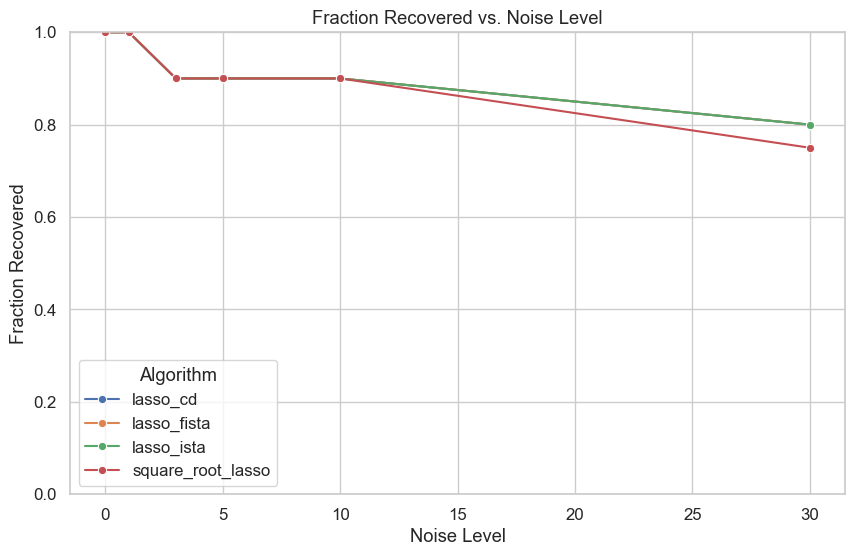

In [33]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(10,6))
sns.lineplot(x="noise", y="Fraction Recovered", hue="Algorithm", data=results_noise, marker="o")
plt.title("Fraction Recovered vs. Noise Level")
plt.xlabel("Noise Level")
plt.ylabel("Fraction Recovered")
plt.ylim(0, 1)
plt.show()


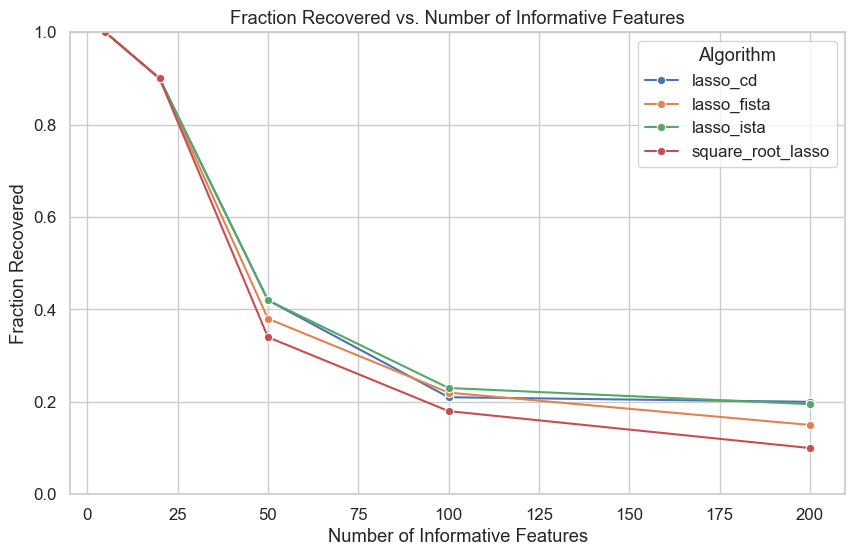

In [34]:
plt.figure(figsize=(10,6))
sns.lineplot(x="n_informative", y="Fraction Recovered", hue="Algorithm", data=results_informative, marker="o")
plt.title("Fraction Recovered vs. Number of Informative Features")
plt.xlabel("Number of Informative Features")
plt.ylabel("Fraction Recovered")
plt.ylim(0, 1)
plt.show()
